# Convergence of the Kalman Gain Approximation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

Some inputs for better axes 

In [2]:
ls = [6, 7, 8, 9, 10]

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

grid_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    grid_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        } )

Multi-Level Ensemble Sizes 

In [4]:
from utils.BasinAnalysis import *

In [5]:
varlvl_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevelsDA/Basin/2023-06-28T11_25_15sharedOmegaLocalised"

In [6]:
center_vars = np.load(varlvl_path+"/center_vars_21600_L2norm.npy")[:-1]
center_diff_vars = np.load(varlvl_path+"/center_diff_vars_21600_L2norm.npy")[:-1]

In [7]:
work_path = "/home/florianb/havvarsel/multilevelDA/scripts/PracticalCost/Basin/2023-06-29T14_54_02"

In [8]:
def raw2costsEnsemble(filename):
    rawCosts = np.load(filename)
    return np.mean(np.sort(rawCosts), axis=1)

In [9]:
costsPure = raw2costsEnsemble(work_path+"/costsPureEnsemble.npy")[:-1]
costsPartnered = raw2costsEnsemble(work_path+"/costsPartneredEnsemble.npy")[:-1]

In [10]:
analysis = Analysis(grid_args_list[:-1], center_vars, center_diff_vars, costsPure, costsPartnered)

In [11]:
taus = [1.25e-1, 1e-1, 7.5e-2, 5.0e-2, 3.5e-2, 2.5e-2]

Nes = []

for tau in taus:
    ML_Ne = analysis.optimal_Ne(tau=tau)
    SL_Ne = np.ceil(analysis.work(ML_Ne)/costsPure[-1]).astype(int)

    Nes.append([ML_Ne, SL_Ne])

Nes

[[array([85, 24,  7,  2], dtype=int32), 17],
 [array([133,  38,  11,   3], dtype=int32), 26],
 [array([236,  66,  19,   4], dtype=int32), 44],
 [array([531, 149,  42,   9], dtype=int32), 99],
 [array([1083,  303,   86,   18], dtype=int32), 200],
 [array([2122,  593,  167,   36], dtype=int32), 392]]

In [12]:
works = [analysis.work(Nes[tau_idx][0]) for tau_idx in range(len(taus))]

## Convergence plot

In [13]:
conv_path = "/home/florianb/havvarsel/multilevelDA/scripts/KGainConvergence/Basin/2023-08-18T11_44_37" 

In [14]:
var_SL = np.loadtxt(conv_path+"/var_SL.txt")
var_ML = np.loadtxt(conv_path+"/var_ML.txt")

errSLGain = np.loadtxt(conv_path+"/errSLGain.txt")
errMLGain = np.loadtxt(conv_path+"/errMLGain.txt")

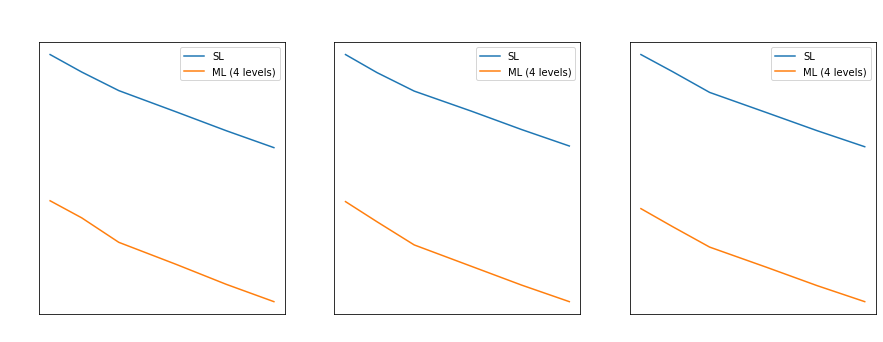

In [25]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Variance of Kalman Gain estimator")
for i in range(3):
    axs[i].loglog(works, var_SL[:,i], label="SL")
    axs[i].loglog(works, var_ML[:,i], label="ML ("+str(len(Nes[0][0]))+" levels)")
    axs[i].legend(labelcolor="black")

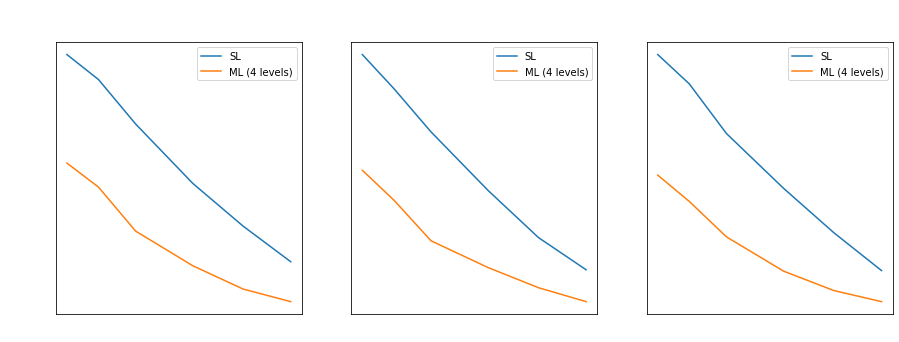

In [27]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("L2(D,Omega)-error vs a 250SL-reference Kalman on a finer level")
for i in range(3):
    axs[i].loglog(works, errSLGain[:,i], label="SL")
    axs[i].loglog(works, errMLGain[:,i], label="ML ("+str(len(Nes[0][0]))+" levels)")
    axs[i].legend(labelcolor="black")